# Final Project

**EMA 550**: Astrodynamics

In [1]:
from utils.lamberts import *
from utils.propagator import *
from utils.constants import *
from utils.ephemerides import *
from utils.orbital_elements import *
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

_bold = '\033[1m'
_reset = '\033[0m'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Problem Parameters

In [2]:
# Time of flight
time_of_flight = 7*24*60*60 # 7 days
launch_time = Time("2022-04-16").unix

# Initial LEO Orbit
initial_leo_coe = make_coe(
    e=0.0,
    a=r_earth+300e3,
    i=obiquity_earth,
    raan=0.0,
    arg_peri=0.0,
    true_anom=0.0)
initial_leo_ephemeris = Ephemeris(pv_from_moe(moe=initial_leo_coe), launch_time)
print(f"{_bold}Initial LEO orbit{_reset}")
print_moe(moe=initial_leo_coe)

# Final orbit (for reference)
print()
print(f"{_bold}Moon's Orbit{_reset}")
print_moe(moe=pv_to_moe(pv=moon_ephemeris.get_pv(t=launch_time)))

Initial LEO orbit
Eccentricity:    0.0
SMA:             6678000.0 m
Inclination:     23.45 deg
Right Ascension: 0.0 deg
Arg Perigee:     0.0 deg
True Anom:       0.0 deg

Moon's Orbit
Eccentricity:    0.06450084830039726
SMA:             390640716.2444101 m
Inclination:     5.217482427324105 deg
Right Ascension: 52.43302882646997 deg
Arg Perigee:     192.42913065407762 deg
True Anom:       310.350564872582 deg


## Lunar Transfer

In [3]:
# Determine where the moon will be at intercept
moon_intercept_pv = moon_ephemeris.get_pv(t=launch_time+time_of_flight)

# Get the pv vector for the transfer orbit
transfer_pv1, transfer_pv2 = lamberts(
    r1_vec=initial_leo_ephemeris.get_pv(t=launch_time)[:3],
    r2_vec=moon_intercept_pv[:3],
    dt=time_of_flight)
transfer_ephemeris = Ephemeris(transfer_pv1, launch_time)

print(f"{_bold}Transfer Orbit{_reset}")
print_moe(moe=pv_to_moe(pv=transfer_pv1))

Transfer Orbit
Eccentricity:    0.9910856595780341
SMA:             202321648.5807107 m
Inclination:     174.82372284218462 deg
Right Ascension: 180.0 deg
Arg Perigee:     62.19820435903484 deg
True Anom:       117.80179564096518 deg


## Plot Trajectory

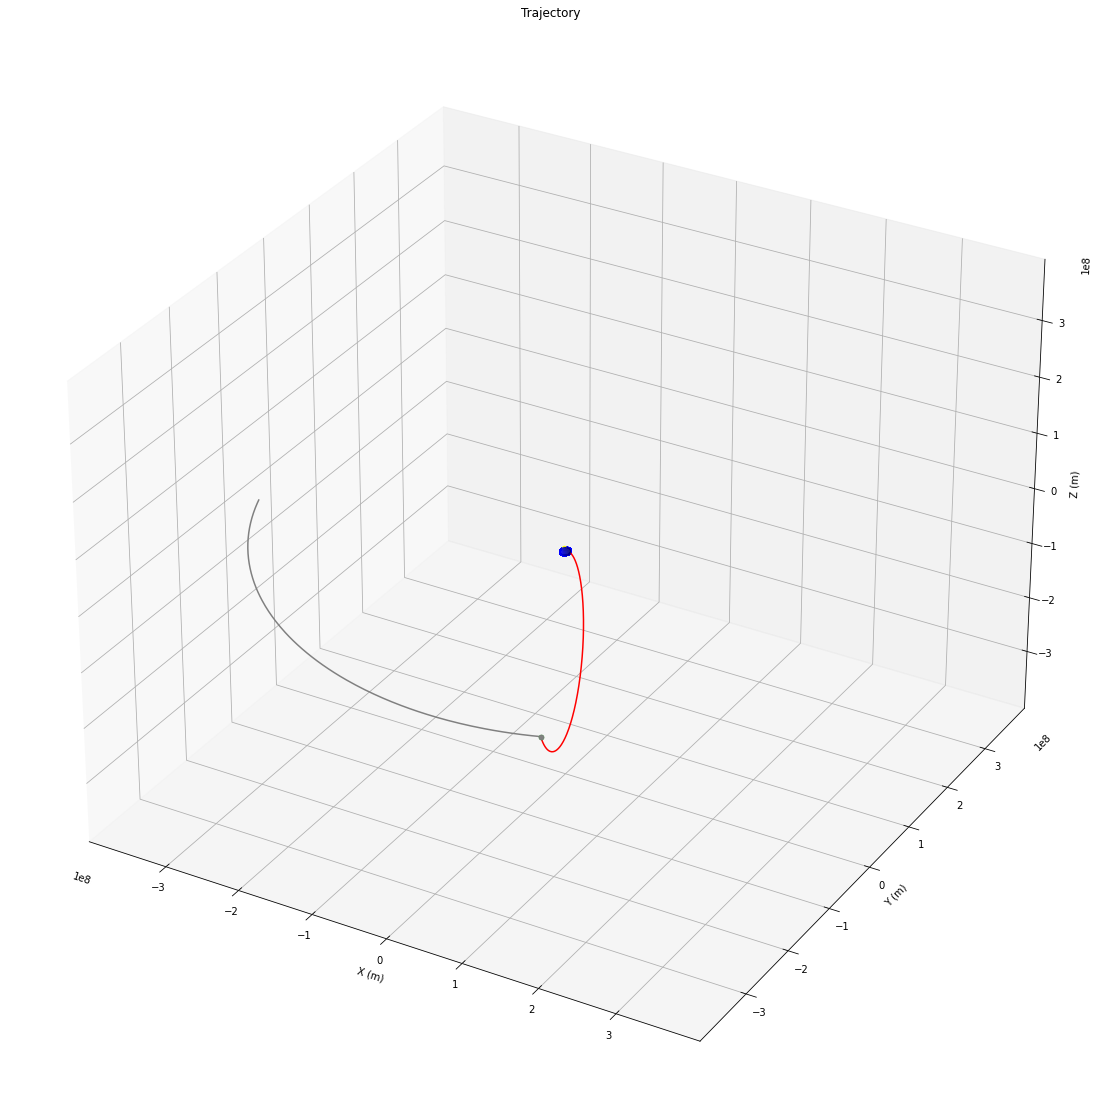

In [4]:
##### Setup #####
fig = plt.figure()
ax = plt.axes(projection='3d')
moon_sma = pv_to_moe(pv=moon_ephemeris.pv0)[1]
ax.set(
    xlim=(-1*moon_sma, moon_sma),
    ylim=(-1*moon_sma, moon_sma),
    zlim=(-1*moon_sma, moon_sma))
plot_earth(
    ax=ax,
    label="Earth")

ax.set_title("Trajectory")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
# ax.legend()

##### interesting bits #####
moon_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Moon",
    pathColor="grey",
    pointColor="grey")
initial_leo_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Initial Orbit",
    pathColor="blue",
    pointColor="yellow")
transfer_ephemeris.plot(
    ax=ax,
    t0=launch_time,
    t1=launch_time+time_of_flight,
    label="Transfer Orbit",
    pathColor="red",
    pointColor="green")